In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.style.use('default')

# 차원 축소
특성이 많으면 많을수록 훈련이 느려지는 것은 둘째치고 데이터가 희소해지면서 과대적합에도 취약해진다.  
다행히도 특성을 줄여서 문제를 해결하는 것이 가능하며 이 경우, 데이터를 시각화 하기도 편해진다.

## 투영
훈련 샘플들은 모든 차원에 걸쳐서 불균일하게 퍼져있다. 차원을 줄여주기 위하여 투영을 시켜주면 되지만....

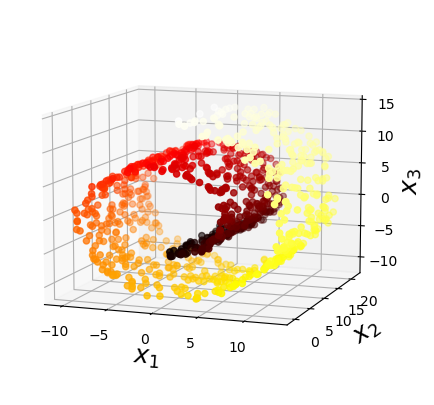

In [2]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

스위스롤 (A.K.A 롤빵) 같이 저런식으로 있으면 특정 방향으로 투영하는 순간 문제가 발생한다.   
이와 같이 ***d차원으로 보일 수 있는 n차원 공간의 일부를 d차원 매니폴드*** 라고 부른다.  
많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링 하는 식으로 작동한다.  
이는 데이터셋이 차원이 낮은 매니폴드에 더 가깝게 놓여있다는 매니폴드 가정/가설에 근거한다.  
이렇게 차원이 낮은 매니폴드 공간에 표현되면 작업이 단순해질 것 같지만 아래 예시처럼 항상 옳지는 않다.

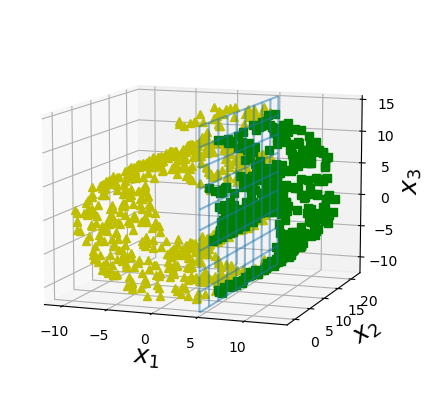

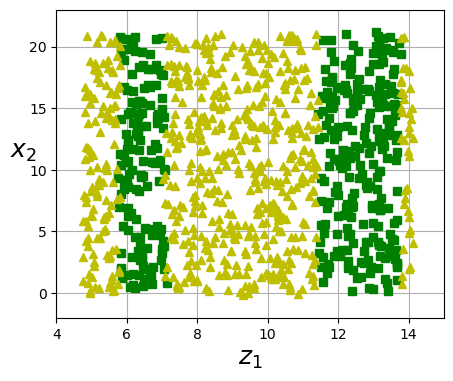

In [3]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()


3차원 공간에서는 단순하게 $X_{1} = 5$ 평면을 기준으로 나누면 되지만 굳이 2D 차원으로 내렸다가 복잡해졌다.  
이처럼 훈련 세트의 차원을 감소하면 속도는 빨라져도 단순한 솔루션을 항상 만들어 주지는 않는다.

## 주성분 분석 (Principal Component Analysis, PCA)
PCA는 데이터에 가장 가까운 초평면 (현재 차원보다 하나 낮은 공간)을 정의한 다음 데이터를 이 평면에 투영시킨다.

### 분산 보존
초평면에 데이터를 투영할 때 옳바른 초평면을 선택해야 한다. 여러 초평면이 있겠지만 그 중 중요한 것이 분산이다.  
분산이 최대로 보존되는 축을 선택하면 정보가 가장 적게 손실되므로 가장 합리적.  
다르게 말하면 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화 해야한다.  

### 주성분 찾기
PCA는 훈련 셋에서 분산이 최대인 축을 찾고 계속해서 이전 축과 직교하면서 분산이 최대인 다음 축을 찾는다.  
이 과정에서 i번째 축을 i번째 주성분 (Principal Component)라고 한다.  
이 주성분을 찾는 과정은 특잇값 분해 (singular value decomposition, SVD) 라는 행렬 분해 기술을 통해 이뤄진다.  
이를 이용하여 분해하면 행렬 $X$가 3 개 행렬의 행렬 곱셈인 $U\sum V^{T}$ 로 분해된다.  
여기서 찾고자 하는 모든 주성분의 단위 벡터가 주성분 행렬 $V$에 담겨있게 된다.

### d차원에 투영하기
주성분을 모두 추출했다면 처음 d개의 주성분으로 정의한 초평면에 현재 데이터를 투영시키면 데이터를 d차원으로 축소가능.  
해당 초평면은 원본 데이터의 분산을 최대로 보존하는 투영임이 보장되고 축소된 데이터셋은 다음과 같은 식을 통해 구한다.
\begin{equation}
    X_{d-proj} = X W_{d}
\end{equation}
여기서 $X_{d-proj}$는 d차원으로 축소된 행렬 $X$ 이고, $W_{d}$는 주성분 행렬 $V$의 첫 d열로 구성된 행렬

In [4]:
from sklearn.decomposition import PCA
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

print("주성분 벡터의 전치 행렬은 pca.components_에 담겨있다\n",pca.components_,"\n")
print(X2D[:5])

주성분 벡터의 전치 행렬은 pca.components_에 담겨있다
 [[-0.93636116 -0.29854881 -0.18465208]
 [ 0.34027485 -0.90119108 -0.2684542 ]] 

[[ 1.26203346  0.42067648]
 [-0.08001485 -0.35272239]
 [ 1.17545763  0.36085729]
 [ 0.89305601 -0.30862856]
 [ 0.73016287 -0.25404049]]


### 설명된 분산의 비율 (explained variance ratio)
pca.explained_variance_ratio_에 저장된 주성분의 설명된 분산 비율은  
각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타낸다.  
여기서 각 주성분에 원본 데이터셋의 분산이 어떻게 퍼져있는지를 보여준다.  
(1번째에 84.2%, 2번째에 14.6% 이런 식)

In [5]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

### 적절한 차원 수 선정
축소할 차원 수는 충분한 분산이 남을 때 까지 더해야 한다.  
시각화를 위해 2D, 3D를 많이 고르곤 한다.

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)  # 설명된 분산 비율의 누적합을 저장
d = np.argmax(cumsum >= 0.95) + 1  # 분산이 0.95 이상인 곳을 저장한다
d  # 154차원에서 분산이 0.95 이상이 된다.

154

### 압축된 표본 되돌리기
위의 경우 처럼 분산의 95%만 남기더라도 실제 데이터셋은 20%만 남아있을 수 있다.  
이 처럼 데이터 셋의 크기 축소는 분류 알고리즘의 속도를 늘릴 수 있으며 또 다시 원본으로 돌릴 수 있다.  
PCA 투영식을 조금 변형시키면 다음 식을 이용하여 역변환이 가능하다. 
\begin{equation}
    X_{recovered} = X_{d-proj} W_{d}^{T}
\end{equation}

### 랜덤 PCA
PCA에서 svd_solver 파라미터를 "randomized"로 지정하면 랜덤 PCA라는 확률적 알고리즘을 통하여  
처음 d개의 PC에 대한 근삿값을 빠르게 찾아준다.  
완전한 행렬 분해 SVD의 시간 복잡도인 $O(mn^{2}) + O(n^{3})$ 이 아닌 $O(md^{2}) + O(d^{3})$이기에  
d가 n보다 많이 작다면 완전 SVD보다 빠르다.  
사이킷런의 PCA의 svd_solver 기본값은 auto로 되어 있어서 n또는 m이 500보다 크거나  
d가 m,n보다 80%보다 작으면 랜덤 PCA를 이용한다.  
만약 완전 SVD를 무조건 이용하고 싶다면 full로 지정하자.

### 점진적 PCA
PCA의 문제는 SVD (특잇값 분해)를 위하여 전체 훈련 셋을 메모리에 올려야 한다는 점이다.  
점진적 PCA덕분에 훈련 셋을 미니배치로 나누어 incremental PCA에 주입시키면 된다.  
훈련셋이 크거나 온라인으로 즉각 PCA를 적용하는 것이 가능하다.

In [7]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

## 커널 PCA
SVM에서 커널 트릭을 이용하여 고차원 공간을 매핑하여 비선형 분류와 회귀를 진행했었다.  
PCA 또한 차원 축소를 위하여 커널 트릭을 이용하여 복잡한 비선형 투영을 수행할 수 있다.  
이를 **커널 PCA (kPCA)** 라고 하며 투영된 후에 샘플의 군집을 유지하고 꼬인 매니폴드를 펼칠 때 유용하다.

In [8]:
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)
X_reduced

array([[-0.20318153, -0.04192012],
       [-0.12291985, -0.08891651],
       [ 0.06294914, -0.06770846],
       ...,
       [-0.01755176,  0.50273796],
       [-0.09990453,  0.00253754],
       [-0.19161337, -0.0417062 ]])

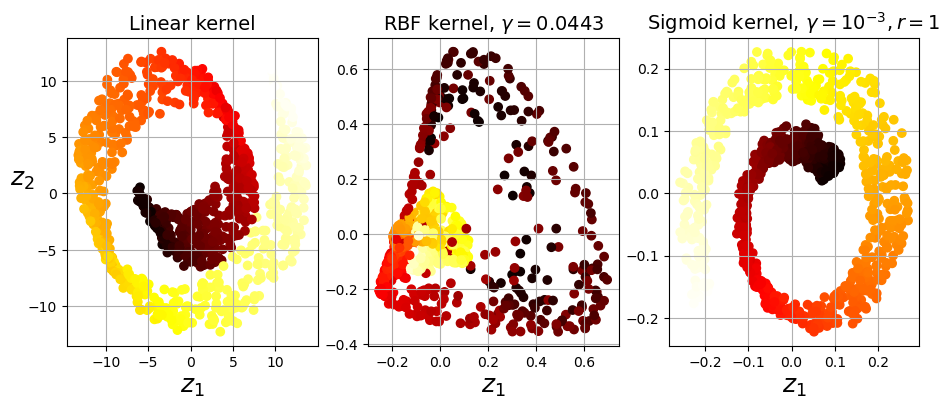

In [9]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2,
                    kernel="linear",
                    fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2,
                    kernel="rbf",
                    gamma=0.0443,
                    fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2,
                    kernel="sigmoid",
                    gamma=0.001,
                    coef0=1,
                    fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"),
                            (132, rbf_pca, "RBF kernel, $\gamma=0.0443$"),
                            (133, sig_pca,
                             "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced

    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### 커널 선택과 하이퍼파라미터 튜닝
kPCA는 비지도 학습이다 보니 명확한 성능 측정의 기준이 없다.  
차원 축소는 종종 지도 학습의 전처리 단계에 활용되므로 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선정가능.  
다음 파이프 라인은 차원 축소를 진행하고 로지스틱회귀를 적용하는데 이를 위해 GridSearchCV를 사용하자.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([("kpca", KernelPCA(n_components=2)),
                ("log_reg", LogisticRegression())])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


완전 비지도 학습 방법으로 가장 낮은 재구성 오차를 만드는 커널과 하이퍼 파라미터를 고르는 방식이 있다.  
하지만 재구성이 선형 PCA만큼 쉽지않다. 하지만 **원본 공간에 kPCA를 적용하여 축소한 것과  
특성맵을 이용하여 무한 차원의 특성 공간에 매핑한 다음, 선형 PCA를 이용해 투영한 것은 수학적으로 동일하다.**  
축소된 공간에 있는 샘플에 대하여 선형 PCA를 역전시키면 재구성된 데이터 포인트가 무한 차원에 위치한다.  
재구성된 포인트와 에러를 계산할 수 없지만 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트를 찾을 수 있다.  
이를 **재구성 원상 (pre-image)** 라고 부르고 재구성 오차인 원본 샘플과 제곱 거리(분산)를 측정할 수 있다.
<br>
재구성은 투영된 샘플을 훈련 셋으로 두고 원본 샘플을 타깃으로 하는 회귀 모델을 훈련시켜서 진행한다.  

In [11]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
                    # fit_inverse_transform를 통해 원본 샘플을 복원시키도록 학습시킨다.
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576611

## LLE (Localy Linear Embedding)

지역 선형 임베딩은 위와 다른 비선형 차원 축소의 일종이며 이전과 달리 투영에 의존하지 않는 매니폴드 학습이다.  
각 훈련 샘플이 가장 가까운 이웃(closest neighbor)과 얼마나 선형적으로 연관이 있는지 측정한다.  
그 다음 지역적인 관계가 가장 잘 보존되는 훈련셋의 저차원적인 표현을 구해준다.  
LLE는 샘플간 거리를 유지하며 잡음이 많지만 않다면 꼬인 매니폴드를 잘 펼쳐준다.

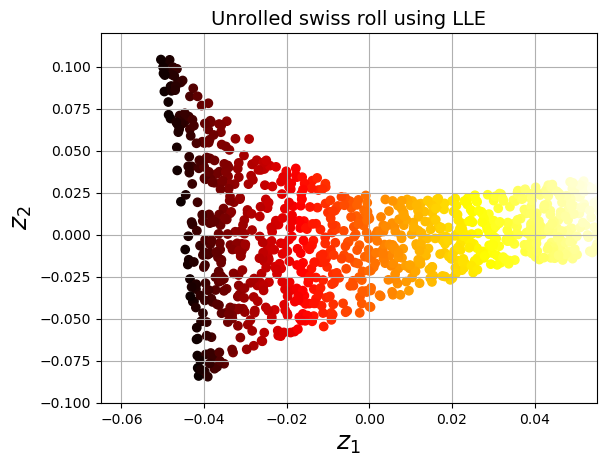

In [12]:
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

LLE가 작동하는 방식은 우선 다음과 같다.  
1. 먼저 알고리즘이 각 훈련 샘플 $x^{(i)}$ 에 대해 가장 가까운 샘플 k개를 찾는다.  
그 다음 k개의 이웃에 대한 선형 함수로 $x^{(i)}$를 구성한다.  
이를 위하여 다음과 같은 식을 사용하여 가중치 행렬 $W$를 만든다.  
\begin{equation}
    \hat{W} = \underset{W}{argmin} \sum_{i=1}^{m}(x^{(i)}-\sum_{j=1}^{m}w_{i,j}x^{(j)})^{2}
\end{equation}
단, $x^{(j)}$가 최근접 이웃 k개 중 하나가 아니라면 $w_{i,j}=0$ 이고 $w_{i,j}$의 합은 1

2. 이 단계를 거치면 가중치 행렬 $\hat{W}$ 은 훈련 샘플 사이에 있는 지역적인 선형 관계를 담고 있다.  
이제 이 관계가 보존되도록 훈련 샘플을 d차원 공간 (d<n)으로 매핑한다.  
만약 $z^{(i)}$ 가 축소하고자 하는 d차원 공간에서 $x^{(i)}$의 상이라면  
가능한 한 $z^{(i)}$ 와$\sum_{j=1}^{m}w_{i,j}z^{(j)}$이 최소가 되어야 한다.
\begin{equation}
    Z = \underset{Z}{argmin} \sum_{i=1}^{m}(z^{(i)}-\sum_{j=1}^{m}w_{i,j}z^{(j)})^{2}
\end{equation}
<br>
* 과정 1과 유사해 보이지만 과정1은 거리를 기반으로 가중치를 찾는 과정이고 과정 2는 가중치를 기반으로 위치 $z$를 찾는다.  
* 사이킷런 상에서 LLE의 계산 복잡도는 k개의 가까운 이웃을 찾고 n차원 공간에서 m개의 샘플에 대해 진행할 때  
이웃을 찾는데 $O(m\log(m)n\log(k))$  
가중치 최적화에 $O(mnk^{3})$  
저차원 표현을 만드는 데 $O(dm^{2})$ 이다.
* 마지막에 저차원 표현을 만들 때 샘플의 제곱 스케일로 계산 복잡도를 가지기에 대용량 셋에 적용되기가 어렵다.

## 다른 차원 축소 기법

### 랜덤 투영
말 그대로 그냥 랜덤한 선형 투영으로 데이터를 저차원으로 투영시킨다.  
놀랍게도 투영 시킨 후에도 거리를 잘 보존하는 것이 수학적으로 증명됬다.  
차원 축소 품질은 샘플 수와 목표 차원수에 따라 다르다. 그런데 정작 초기 차원수와는 상관이 없다.

### 다차원 스케일링
샘플 간의 거리를 보존하면서 차원을 축소시킨다 (LLE...?)

### Isomap
각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만들고 이 후 노드간 최단 경로를 이루는 노드 수인  
**지오데식 거리(geodesic distance)** 를 유지하면서 차원을 축소한다.

### t-SNE (t-distributed stochastic neighbor embedding)
비슷한 샘플은 가까이, 비슷하지 않으면 멀리 보내버리면서 차원을 축소시킨다.  
시각화에서 많이 이용되고 고차원 샘플에서 샘플의 군집을 시각화할 때 이용된다.

### 선형 판별 분석 linear discriminant analysis(LDA)
분류 알고리즘이지만 훈련 과정에서 클래스 사이를 가장 잘 구분하는 축을 학습한다.  
이 축을 기반으로 데이터가 투영되는 초평면을 정의한다. 이 알고리즘이 이미 투영을 통해 가능한 한  
클래스를 멀리 떨어지게 유지 시키기에 SVM과 같은 다른 분류 알고리즘을 적용하기 전에 차원을 축소시키기 좋다.